# **Parameter Optimisation for GITT** 

This notebook is created to provide an example for ```GITT``` optimisation problem. Diffisuion Coefficient is optimised in this notebook. 24 seperate discharge pulses are used in here.
 The workflow is as follows:


In [1]:
#%pip install git+https://github.com/paramm-team/pybamm-param.git -q # For Colab use
import pybamm
import pbparam
import pandas as pd
import os
import numpy as np

pulse_folder_path = (os.path.join(pbparam.__path__[0], "input", "data/GITT"))
OCP_folder_path = (os.path.join(pbparam.__path__[0], "input", "data"))

# Get a list of all files in the folder
all_files = os.listdir(pulse_folder_path)

# Filter the list to get only .csv files
csv_files = [file for file in all_files if file.endswith('.csv')]

In [2]:
# Extract pulse numbers from filenames and sort them
pulse_numbers = [int(file_name.split('_')[1].split('.csv')[0]) for file_name in csv_files]
sorted_files_by_pulse = [f"pulse_{num}.csv" for num in sorted(pulse_numbers)]

# Loop through each CSV file and read it into a DataFrame
dfs = {}  # Store each DataFrame in a dictionary with the filename as the key

# Read all the pulses in the folder
for csv_file in sorted_files_by_pulse:
    file_path = os.path.join(pulse_folder_path, csv_file)
    dfs[csv_file] = pd.read_csv(file_path)

In [3]:
# Reading half cell data for OCP balance
cathode_half_lit = pd.read_csv(os.path.join(OCP_folder_path,"cathode_OCP_2_lit.csv")) # Half cell lithiation data
cathode_half_delit = pd.read_csv(os.path.join(OCP_folder_path,"cathode_OCP_2_delit.csv")) # Half cell delithiation data

In [4]:
## OPTIONAL ##
# If the charge is already calculated, it can be used instead of this.

# Calculation of Charge (A.h)

def compute_cumulative_charge(currents, times, starting_charge):
    q_values = [starting_charge]
    for i in range (1, len(currents)):
        dt = (times[i] - times[i-1]) / 3600
        dq = 0.5 * np.abs(currents[i]+currents[i-1]) * dt
        q_values.append(q_values[-1] + dq)
    return q_values

In [5]:
# Charges are calculated and added as a new column to the dataframe.
starting_charge = 0
for name, df in dfs.items():
    currents = df["Current [A]"].tolist()
    times = df["Time [s]"].tolist()
    q_values = compute_cumulative_charge(currents, times, starting_charge)
    starting_charge = q_values[-1]
    dfs[name]['Charge (A.h)'] = q_values

In [6]:
# Individual pulses can be printed as below.
dfs["pulse_1.csv"]

,Time [s],Voltage [V],Current [A],Negative electrode potential [V],Positive electrode potential [V],Charge (A.h)
0,105749.3767,4.147639,0.000000e+00,0.090113,4.237751,0.000000e+00
1,105809.3769,4.147734,0.000000e+00,0.090017,4.237751,0.000000e+00
2,105869.3771,4.147772,0.000000e+00,0.089998,4.237771,0.000000e+00
3,105927.2243,4.147811,0.000000e+00,0.089998,4.237809,0.000000e+00
4,105927.2727,4.147582,-5.790000e-10,0.089998,4.237580,3.892167e-15
...,...,...,...,...,...,...
90,107185.0980,4.110606,0.000000e+00,0.092632,4.203238,2.875058e-04
91,107226.1511,4.111618,0.000000e+00,0.092193,4.203811,2.875058e-04
92,107286.1513,4.111560,0.000000e+00,0.092193,4.203754,2.875058e-04
93,107346.1515,4.111942,0.000000e+00,0.092041,4.203982,2.875058e-04


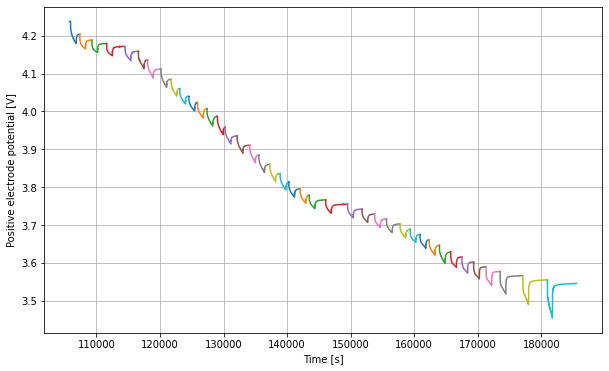

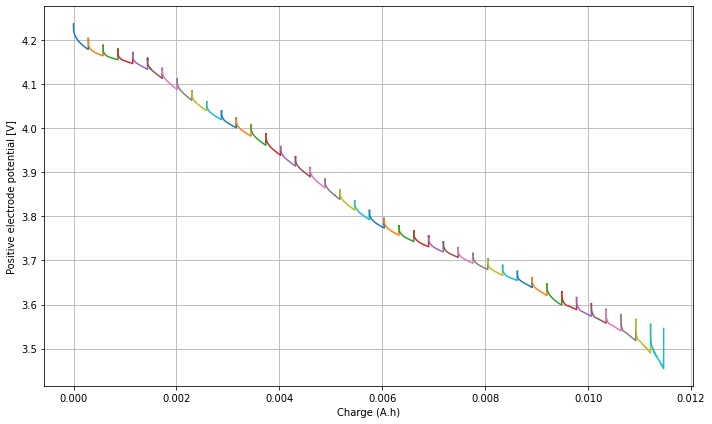

In [7]:
# Both of the Voltage vs Time and Charge can be plotted as below.

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
fig2, ax2 =plt.subplots(figsize=(10, 6))
for file_name, df in dfs.items():
    ax.plot(df['Time [s]'], df["Positive electrode potential [V]"])
    ax2.plot(df['Charge (A.h)'], df["Positive electrode potential [V]"])
ax.set_xlabel('Time [s]')
ax2.set_xlabel('Charge (A.h)')
ax.set_ylabel('Positive electrode potential [V]')
ax2.set_ylabel('Positive electrode potential [V]')
ax.grid(True)
ax2.grid(True)
plt.tight_layout()
plt.show()

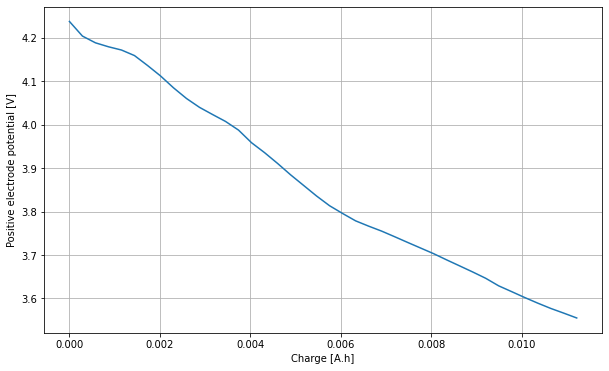

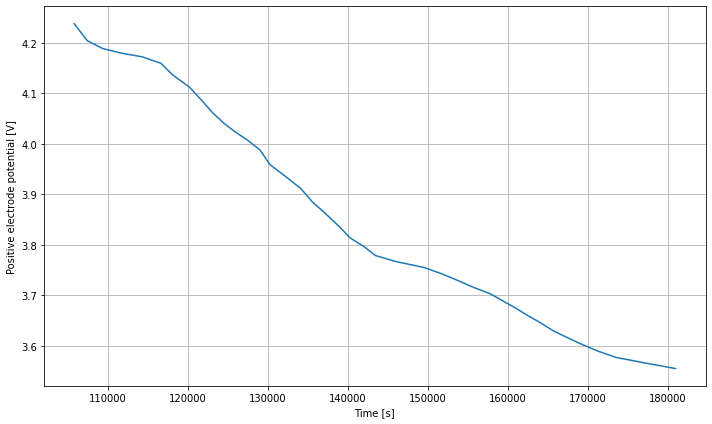

In [8]:
# Create a list to collect the first value from each pulse (DataFrame)

# saving the first values of each pulse.
first_values = [df['Positive electrode potential [V]'][0] for _, df in dfs.items()]
time_val = [df['Time [s]'][0] for _, df in dfs.items()]
charge_val = [df['Charge (A.h)'][0] for _, df in dfs.items()]

# Plotting the first values.
fig, ax = plt.subplots(figsize=(10, 6))
fig2, ax2 = plt.subplots(figsize=(10, 6))
ax.plot(charge_val,first_values)
ax2.plot(time_val,first_values)
ax2.set_xlabel('Time [s]')
ax.set_xlabel('Charge [A.h]')
ax.set_ylabel('Positive electrode potential [V]')
ax2.set_ylabel('Positive electrode potential [V]')
ax.grid(True)
ax2.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# OCP balance will be performed using Charge

# First, pulse values are stored in a DataFrame for OCP.
pulse_values= pd.DataFrame(data={'Charge [A.h]': charge_val, 'Voltage [V]':first_values})

# OCP balance optimisation problem is defined here.
ocp_balance_cathode = pbparam.OCPBalance(
    [cathode_half_lit, cathode_half_delit],
    [pulse_values, pulse_values],
    
    cost_function=pbparam.MLE(),
)

In [10]:
# OCP balance optimiser is defined.
optimiser = pbparam.ScipyMinimize(method="Nelder-Mead")

In [11]:
# OCP result is calculated at this step.
result_cathode = optimiser.optimise(ocp_balance_cathode)

In [12]:
# Results are printed.
print("Cathode Results: ",result_cathode)

Cathode Results:  
             Optimal values: {'Shift': -0.0046924494850563055, 'Stretch': 0.016877104212004102}
             Initial values: None
        Cost function value: -1646.5708939572546
                 Solve time: 1.309 s
                    Message: Optimization terminated successfully.
        


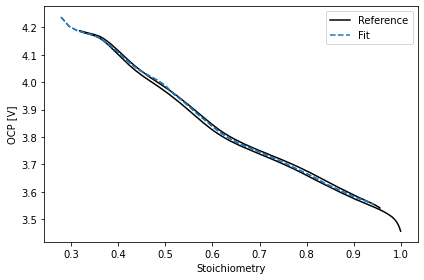

In [13]:
result_cathode.plot();

In [14]:
# For BasicGITT, we need derivatives of each pulse which can be calculated as:
grad = np.gradient(first_values,charge_val) * result_cathode.result_dict['Stretch']

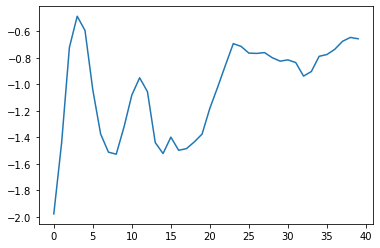

In [15]:
# Gradients are plotted.
plt.plot(grad)

PbParam model to be used for GITT needs to be defined:

In [16]:
# model = pbparam.BasicGITT()
model = pbparam.WeppnerHuggins()

Then, Optimisation method should be defined in this step. DiferentialEvolution(https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html) or ScipyMinimize(https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)

can be used to minimise cost function. For faster results, ScipyMinimize with ```"Nelder-Mead"``` method can be used. However, ScipyDifferentialEvolution is more robust and has provided lower errors for most of the cases. 

In [17]:
# optimiser = pbparam.ScipyDifferentialEvolution(
#     extra_options={"workers": 4, "polish": True, "updating": "deferred", "disp": True}
# )
optimiser = pbparam.ScipyMinimize(method="Nelder-Mead")

Next, parameter dictionary needs to be defined with all of the required parameters:

In [18]:
param_dict=pybamm.ParameterValues({
        "Reference OCP [V]": first_values[0],
        "Derivative of the OCP wrt stoichiometry [V]": grad[0],
        "Current function [A]": 1.15e-3,
        "Number of electrodes connected in parallel to make a cell": 1.0,
        "Electrode width [m]": np.pi * (1.8e-2) ** 2 / 4,   # effective area for a coin cell with 18 mm diameter
        "Electrode height [m]": 1,
        "Positive electrode active material volume fraction": 0.665,
        "Positive particle radius [m]": 5.22e-6,
        "Positive electrode thickness [m]": 75.6e-6,
        "Positive electrode diffusivity [m2.s-1]": 5e-14,
        "Maximum concentration in positive electrode [mol.m-3]": 63104,
        "Initial concentration in positive electrode [mol.m-3]": 1000,
        "Effective resistance [Ohm]": 0,
        'Negative electrode thickness [m]': 0.0001,
        'Separator thickness [m]': 0.0001,
        'Negative particle radius [m]': 1e-05,
    })

The Diffusuvity is optimised for every pulse in a loop as below:

In [19]:
i = 0
results = []
diffusions = []
for name, df in dfs.items():
    # We are doing this for positive electrode potential 
    # but it needs to be converted to 'Voltage [V]'
    pulse_data = df.filter(items=['Time [s]', 'Positive electrode potential [V]'])
    pulse_data.rename(columns={'Positive electrode potential [V]': 'Voltage [V]'}, inplace=True)
    
    # pulse data is filtered to remove currents below the threshold.
    pulse_data = pulse_data[df["Current [A]"] <= -1e-3]

    # Time [s] should start from 0 for every pulse! (Otherwise it will NOT work!)
    pulse_data['Time [s]'] = pulse_data['Time [s]'] - pulse_data['Time [s]'].iloc[0]

    #Parameter dictionary updated for every pulse
    param_dict.update({
        "Reference OCP [V]": pulse_data['Voltage [V]'].iloc[0],
        "Derivative of the OCP wrt stoichiometry [V]": grad[i],
    })

    # Optimisation problem is defined here.
    opt = pbparam.GITT(param_dict=param_dict,gitt_model=model, data=pulse_data, cost_function=pbparam.MLE())

    #Optimisation is done in step and saved in result.
    result = optimiser.optimise(opt)

    # Diffisuion coefficient is the first one in the result.
    diffusions.append(result.x[0])

    # They can be plotted using:
    #
    # result.plot()
    
    # All of the results are stored.
    results.append(result) 
    i +=1

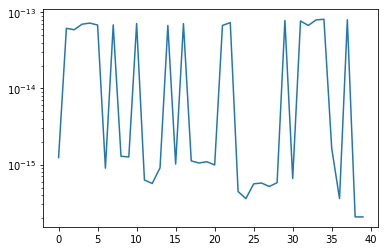

In [20]:
plt.semilogy(diffusions)

In [21]:
print(diffusions)

[1.2379577175984046e-15, 6.158359878328833e-14, 5.897872018335915e-14, 6.968054953309874e-14, 7.213801127778964e-14, 6.795369234038367e-14, 8.9850402594771e-16, 6.822464696845229e-14, 1.2869456900180106e-15, 1.2622482853336792e-15, 7.116447522692258e-14, 6.289940133500085e-16, 5.655646884061927e-16, 9.096076543379901e-16, 6.706450995915396e-14, 1.017511439656199e-15, 7.08168812973532e-14, 1.119513095507677e-15, 1.0504269240210526e-15, 1.0925777977020489e-15, 9.90453906930637e-16, 6.716854039238238e-14, 7.312137437878728e-14, 4.438610178532446e-16, 3.583696816258056e-16, 5.596256919641384e-16, 5.739342828929275e-16, 5.16807456536242e-16, 5.800062347644959e-16, 7.801778498874007e-14, 6.585754323720707e-16, 7.677326167232015e-14, 6.713901929233284e-14, 7.939466012791452e-14, 8.098483919097548e-14, 1.6331984233920947e-15, 3.5874449271896374e-16, 7.966442612905671e-14, 2.0600000000589956e-16, 2.0600000000001686e-16]


The result for each pulse can be accessed as:

In [22]:
print(results[1])


             Optimal values: {'Positive electrode diffusivity [m2.s-1]': 6.158359878328833e-14, 'Reference OCP [V]': 4.182620698916297, 'Standard deviation of voltage [V]': 0.007828196100361881}
             Initial values: {'Positive electrode diffusivity [m2.s-1]': (5e-14, (2.06e-16, 2.06e-12)), 'Reference OCP [V]': (4.2, (0, 5))}
        Cost function value: -151.01423727963254
                 Solve time: 542.503 ms
                    Message: Optimization terminated successfully.
        
